## Regional GDP
In this notebook, we will explore how the trend in quarterly GDP (in 2019 pounds). The data is based on the GDP disaggreggated by industry and regions of England and Wales. This is synthesize with the GDP index which is disaggregated at the same level. The latest published edition (Feb 2023) contains GDP index up to the third quarter of 2023.

In most cases, seasborn is used to produced quick plots for exploration. To plot graphs intended for publication, we will mostly use matplotlib artist object methods that offers greater flexibility and build the plot from scratch.

In [2]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.lines import Line2D

# define matplotlib rc params
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.bottom'] = "off"
plt.rcParams['axes.spines.top'] = "off"
plt.rcParams['axes.spines.right'] = "off"
plt.rcParams['axes.spines.left'] = "off"

## 1. Explore the Regional GDP by Quarter
The source of the dataframe can be found in the [01_download_csv.ipynb](01_download_csv.ipynb). It is made available using the beta API developed by the ONS.

In [5]:
file = "./data/regional-gdp-by-quarter.csv"
print(f"loading {file}")
# parse df
df = pd.read_csv(file,index_col=0)
df.head()

loading ./data/regional-gdp-by-quarter.csv


,v4_1,Data Marking,yyyy-qq,Time,nuts,Geography,sic-unofficial,UnofficialStandardIndustrialClassification,type-of-prices,Prices,quarterly-index-and-growth-rate,GrowthRate
0,12.0,NaN,2015-q1,2015 Q1,UK0,England,D,"D: Electricity, gas, steam and air conditionin...",cvm,Chained volume measure,grq,Quarterly growth rate on previous quarter
1,29.7,NaN,2015-q1,2015 Q1,UKC,North East,D,"D: Electricity, gas, steam and air conditionin...",cvm,Chained volume measure,grq,Quarterly growth rate on previous quarter
2,-7.6,NaN,2015-q1,2015 Q1,UKL,Wales,A,"A: Agriculture, forestry and fishing",cvm,Chained volume measure,grq,Quarterly growth rate on previous quarter
3,1.4,NaN,2015-q1,2015 Q1,UKL,Wales,A--T,A-T: Total,cvm,Chained volume measure,grqa,Quarterly growth rate on same quarter of previ...
4,59.5,NaN,2015-q1,2015 Q1,UKI,London,B,B: Mining and quarrying,cvm,Chained volume measure,qix,Quarterly index


In [6]:
# parse the date of the data
df['year'] = df['yyyy-qq'].apply(lambda x: x[0:4])
df['quarter'] = df['yyyy-qq'].apply(lambda x: x[-2:])
df['mm-dd'] = df['quarter'].map({"q1":"02-14","q2":"05-15","q3":"08-15","q4":"11-15"})
df['timestamp'] = pd.to_datetime(pd.Series(df['year'] +"-" +  df['mm-dd']))

# subset only the relevant columns
cols = ['Geography','timestamp','GrowthRate','sic-unofficial','UnofficialStandardIndustrialClassification','v4_1']
df = df[cols]
# rename the columns
df.columns = ['geography','timestamp','index','industry_code','industry','value']


## 3. Quartarly Index
For detailed methodology, see [ONS](https://www.ons.gov.uk/economy/grossdomesticproductgdp/methodologies/grossdomesticproductgdpukregionsandcountriesqmi).
Key points to note:
* The index is adjusted for inflation using the national quarterly deflator. i.e. the index is a ratio of real gdp compared to the baseline-year (2019)
* While the GVA (absolute value for GDP using the value-added estimation approach) is aggregated annually, the quarterly GDP index represent the average quarterly GVA. In other words, the quarterly GDP index in the baseline year (2019) averages at 100 across an entity (a geogrpahy, industry pair).
* These estimated is computed using the VAT

To transform the number into absolute value of GDP, we need to multiply the index with the nominal value of GDP in 2019. This data can be found in the [dataset](https://www.ons.gov.uk/file?uri=/economy/grossvalueaddedgva/datasets/nominalandrealregionalgrossvalueaddedbalancedbyindustry/current/regionalgrossvalueaddedbalancedbyindustryandallitlregions.xlsx). Note that this dataset records the GDP annually, and there is no data recorded after 2023. Hence, there is a benefit of merging the two dataset GDP index with the GVA dataset. The GVA is an estimate of the GDP using the value-added approach. This is recorded in 2019 million pounds in Table1b.

Office for National Statistics (ONS), released 3 February 2023, ONS website, methodology, Gross domestic product (GDP), UK regions and countries QMI.


### 3.1 Maniputate GVA Table
In the GVA table, the industry is broken down by SIC07 codes. The most granular data is  group by a single industry that is represented by a 1-2 digit numerical data. Aggregates of an industry is represented by a single alphabetical character group. For example, the group:
<center>S (94-96)</center>

The "S" here represents "Other service activities" which is an aggregate of industry code 94-96:
* 94 - Activities of membership organisations
* 95 - Repair of computers, personal and household goods
* 96 - Other personal service activities 

These are further aggregated to form 4  break downs by the level of production
* A: Agriculture, forestry and fishing
* B-E: Production Industry
* F: Construction
* G-T: Wholesale and retail trade
* A-T: Total

In [7]:
# loading the gva table
gva = pd.read_excel("./data/regionalgrossvalueaddedbalancedbyindustryandallitlregions.xlsx", sheet_name="Table1b" ,
                    skiprows=[0],usecols=["ITL region code",'ITL region name','SIC07 code',"SIC07 description",'2019'])
gva.columns = ["itl_geocode","geography","SIC07_code","SIC07 description","val_2019"]
gva.tail()

,itl_geocode,geography,SIC07_code,SIC07 description,val_2019
1707,UKX,United Kingdom less Extra-Regio,S (94-96),Other service activities,34888
1708,UKX,United Kingdom less Extra-Regio,94,Activities of membership organisations,9355
1709,UKX,United Kingdom less Extra-Regio,95,"Repair of computers, personal and household goods",2653
1710,UKX,United Kingdom less Extra-Regio,96,Other personal service activities,22880
1711,UKX,United Kingdom less Extra-Regio,T (97-98),Activities of households,3917


In [8]:
# conform industry_code with the index df
gva['industry_code'] = gva['SIC07_code'].str.extract(r"([A-Z]{1,2}(-[A-Z]{1,2})*)")[0]

# conform geography "East" as "East of England"
gva.loc[gva["geography"] == 'East', 'geography'] = "East of England"

# subset for rows that contains industry aggregate only
# remove the non-aggregated rows 
gva = gva.dropna(axis = 0,subset = ['industry_code'])
# replace the total row to A-T
gva.loc[gva["SIC07_code"] == 'Total', 'industry_code'] = "A-T"

In [9]:
gva.head()

,itl_geocode,geography,SIC07_code,SIC07 description,val_2019,industry_code
0,UK,United Kingdom,Total,All industries,2000157,A-T
1,UK,United Kingdom,A-E,Production sector,284149,A-E
2,UK,United Kingdom,A (1-3),"Agriculture, forestry and fishing",13531,A
6,UK,United Kingdom,B (5-9),Mining and quarrying,21777,B
9,UK,United Kingdom,C (10-33),Manufacturing,194895,C


## 3.2 Manipulating the absolute index

In [10]:
absolute_ind = df.query("index == 'Quarterly index'")

In [11]:
# pivot the table
ind_pivot = absolute_ind.pivot(index = ["geography","industry"], 
                    columns = "timestamp", values = "value")\
                    .reset_index()
# parse the industry code
ind_pivot['industry_code'] = ind_pivot['industry'].str.extract(r"([A-Z](-[A-Z]{1,2}){0,1})")[0]

# coerce columname of type timestamp to date string %Y-%m&d
ind_pivot.columns = [col_name.strftime("%Y-%m-%d") \
                     if type(col_name) == pd.Timestamp else col_name \
                    for col_name in ind_pivot.columns]

In [12]:
# drop geography: England(aggregate), Extra-regio
ind_pivot = ind_pivot[~ind_pivot['geography'].isin(['England','Extra-regio'])]

## 3.3 Apply Merge for Each Entity (Geography, Industry Pair)

In [13]:
# apply the merge
real_gdp = ind_pivot.merge(gva[["geography","industry_code",'val_2019']], 
                on = ['geography','industry_code'],
                how = 'left')

## re-order the columns
# parse the timestamp column as string object
timestamp_col = pd.Series(
                    real_gdp.columns.\
                    drop(["geography",'industry','industry_code',"val_2019"]))
# define new order
col_order = ["geography",'industry','industry_code',"val_2019"]
col_order.extend(list(timestamp_col))

# store the reordered frame
real_gdp = real_gdp[col_order]


In [14]:
# inspect for na values
real_gdp.isna().sum()
    

geography         0
industry          0
industry_code     0
val_2019         10
2012-02-14        0
2012-05-15        0
2012-08-15        0
2012-11-15        0
2013-02-14        0
2013-05-15        0
2013-08-15        0
2013-11-15        0
2014-02-14        0
2014-05-15        0
2014-08-15        0
2014-11-15        0
2015-02-14        0
2015-05-15        0
2015-08-15        0
2015-11-15        0
2016-02-14        0
2016-05-15        0
2016-08-15        0
2016-11-15        0
2017-02-14        0
2017-05-15        0
2017-08-15        0
2017-11-15        0
2018-02-14        0
2018-05-15        0
2018-08-15        0
2018-11-15        0
2019-02-14        0
2019-05-15        0
2019-08-15        0
2019-11-15        0
2020-02-14        0
2020-05-15        0
2020-08-15        0
2020-11-15        0
2021-02-14        0
2021-05-15        0
2021-08-15        0
2021-11-15        0
2022-02-14        0
2022-05-15        0
2022-08-15        0
dtype: int64

In [15]:
real_gdp[real_gdp['val_2019'].isna()]

,geography,industry,industry_code,val_2019,2012-02-14,2012-05-15,2012-08-15,2012-11-15,2013-02-14,2013-05-15,...,2020-05-15,2020-08-15,2020-11-15,2021-02-14,2021-05-15,2021-08-15,2021-11-15,2022-02-14,2022-05-15,2022-08-15
2,East Midlands,B-E: Production Industries,B-E,NaN,81.1,84.1,85.2,86.0,86.1,91.4,...,84.3,109.0,110.8,111.5,110.8,113.1,108.0,104.0,99.4,94.3
25,East of England,B-E: Production Industries,B-E,NaN,92.0,90.9,93.1,97.2,94.1,93.7,...,86.4,103.4,111.5,111.3,112.9,114.6,112.7,103.5,100.2,98.9
48,London,B-E: Production Industries,B-E,NaN,85.8,84.3,84.0,84.9,89.9,90.7,...,88.9,105.8,107.3,107.4,110.2,107.8,103.9,97.0,93.5,93.8
71,North East,B-E: Production Industries,B-E,NaN,93.9,92.2,96.4,96.5,91.9,97.6,...,82.9,99.9,107.8,114.4,107.9,105.2,99.8,97.5,91.8,90.9
94,North West,B-E: Production Industries,B-E,NaN,81.7,80.5,82.3,85.8,84.7,87.3,...,92.2,110.6,113.2,115.9,117.5,118.1,112.2,105.9,106.4,107.5
117,South East,B-E: Production Industries,B-E,NaN,80.5,86.5,83.5,82.5,83.7,84.3,...,93.2,106.2,112.3,111.5,113.7,110.5,106.8,102.7,97.9,95.5
140,South West,B-E: Production Industries,B-E,NaN,92.7,94.7,93.9,96.7,94.4,92.3,...,88.9,103.5,107.6,110.3,112.9,110.7,105.7,97.4,94.5,93.5
163,Wales,B-E: Production Industries,B-E,NaN,80.7,82.6,83.5,83.3,83.4,84.3,...,88.3,106.6,107.7,106.4,115.4,115.9,112.1,106.0,107.9,99.3
186,West Midlands,B-E: Production Industries,B-E,NaN,72.4,77.5,81.3,81.0,78.7,84.4,...,77.5,98.2,107.6,114.0,109.4,104.8,98.9,89.8,92.4,91.0
209,Yorkshire and The Humber,B-E: Production Industries,B-E,NaN,77.7,78.9,80.8,81.0,79.1,83.8,...,88.2,107.0,111.2,110.7,113.7,114.8,108.9,104.8,104.3,102.6


From the result above, we can see that
* B-E aggregates is not provided from the GVA dataframe. This can be computed by summing up the aggregates from the industry coded B to E (inclusive).

In [16]:
# compute the BE aggregate
BE_aggregate = gva[gva['industry_code'].isin(["B","C","D","E"])]
BE_aggregate = BE_aggregate.groupby(['geography'])['val_2019'].sum()

# fill the BE na value in real_gdp
for ind in real_gdp[real_gdp['val_2019'].isna()].index:
    geography = real_gdp.loc[ind,"geography"]
    real_gdp.loc[ind,"val_2019"] = dict(BE_aggregate)[geography]

## 3.4 Impute for the Real GDP by Year
When multiplying the real GDP number with the GDP index, recall that the index is recorded in percentage terms. Hence, under the for loop below, we divided the column by 100 to get theGDP index in decimal terms. 

In [17]:
# get the 2019 quarter average gdp
real_gdp["val_2019_q_avg"] = real_gdp["val_2019"]/4

# iterate through the timestamp columns
for col in timestamp_col:
    real_gdp[col] = real_gdp[col] / 100 * real_gdp['val_2019_q_avg']

# drop the nominal reference column
real_gdp = real_gdp.drop(columns = ["val_2019","val_2019_q_avg"])

## 4 Data Visualisation
### 4.1 Total Regional GDP

In [18]:
# Subset for total
regionGDP_at = real_gdp.query("industry_code == 'A-T'")

# melt the table
regionGDP_at = regionGDP_at.melt(id_vars= "geography",
                  value_vars = timestamp_col,
                  var_name = "date",
                  value_name = "value")

<Axes: xlabel='date', ylabel='value'>

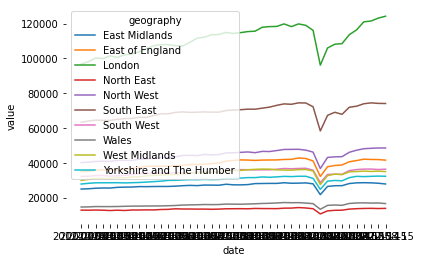

In [19]:
sns.lineplot(data= regionGDP_at,
             x = "date",
             y = 'value',
             hue = 'geography')

In [20]:
# subset relevant columns
gr_2022 = real_gdp[['geography','industry_code','2021-08-15','2022-08-15']]
# subset for the aggregate
gr_2022 = gr_2022.query("industry_code == 'A-T'")
# compute regional growth rate
gr_2022['gr'] = (gr_2022['2022-08-15']-gr_2022['2021-08-15']) / gr_2022['2021-08-15']
# inspect result
gr_2022 = gr_2022.sort_values("gr",ascending= True).reset_index(drop = True)
gr_2022

,geography,industry_code,2021-08-15,2022-08-15,gr
0,East Midlands,A-T,28430.03500,27778.10000,-0.022931
1,Wales,A-T,16869.82875,16513.06500,-0.021148
2,West Midlands,A-T,34944.80850,34908.89400,-0.001028
3,Yorkshire and The Humber,A-T,32184.15200,32216.30400,0.000999
4,South West,A-T,36072.41375,36292.59125,0.006104
5,East of England,A-T,41239.17200,41492.69150,0.006148
6,North East,A-T,13581.94000,13763.96600,0.013402
7,South East,A-T,72490.54450,74045.50000,0.021450
8,North West,A-T,47197.37600,48481.98200,0.027218
9,London,A-T,116350.42400,124218.38300,0.067623


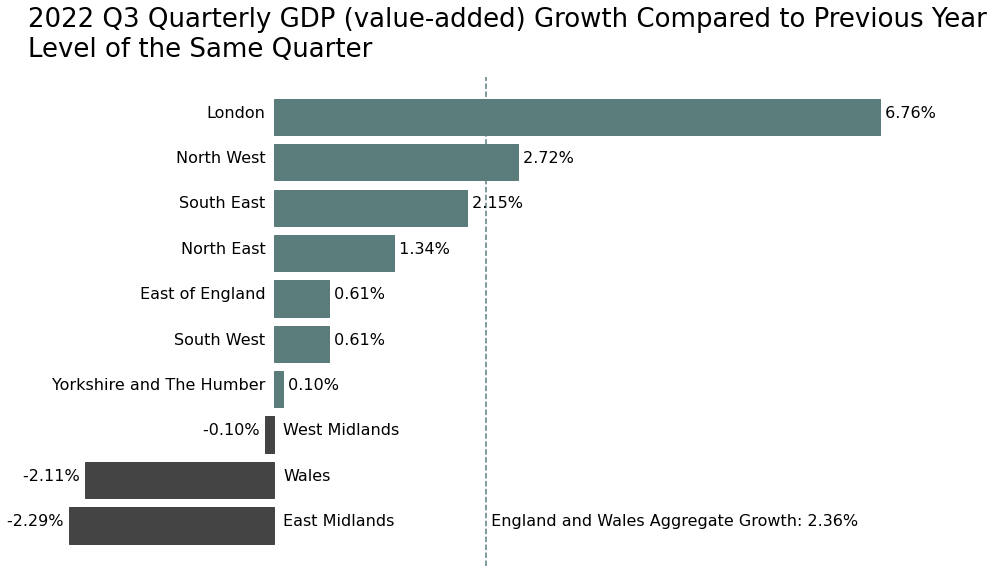

In [21]:
# compute the regional growth
gr_agg = (gr_2022['2022-08-15'].sum() - gr_2022['2021-08-15'].sum()) / gr_2022['2021-08-15'].sum()

## plot the result
# instantiate the plot object
fig, ax  = plt.subplots(figsize = (16,9))

# define the plot parameters
height = 0.8

for i in range(len(gr_2022)):
    y = i 
    x = gr_2022.iloc[i,-1]
    region = gr_2022.iloc[i,0]

    # add annotation
    if x < 0:
        color = "#444444"
        # annotate region
        ax.annotate(region , xy = (0.001,y), fontsize = 16, horizontalalignment = 'left')
        # add bar width
        val_str = f"{x: ,.2%} "
        ax.annotate(val_str, xy = (x,y), fontsize = 16, horizontalalignment = "right")
    else:
        color = "#5A7D7C"
        # annotate region
        ax.annotate(region , xy = (-0.001,y), fontsize = 16, horizontalalignment = 'right')
        # add bar width
        val_str = f"{x: ,.2%} "
        ax.annotate(val_str, xy = (x,y), fontsize = 16, horizontalalignment = "left")

    rects = ax.barh(width = x, y = y, height = height, 
                    color = color, edgecolor = color,
                    )
    
# add england and wales aggregate growth
ax.axvline(gr_agg, linestyle = "--", zorder = 1, color = color)
ax.annotate(f" England and Wales Aggregate Growth: {gr_agg:,.2%}", xy = (gr_agg,0),
                fontsize = 16)
# add title
ax.set_title("2022 Q3 Quarterly GDP (value-added) Growth Compared to Previous Year \nLevel of the Same Quarter",
             fontsize = 26, loc = "left", pad = 20)

# remove the axis ticks
ax.set_xticks([])
ax.set_yticks([])
plt.tick_params(axis='both', width = 0)

#
fig.savefig("./output_image/gdp_gr_by_region.png", bbox_inches = "tight", 
            dpi = 300,pad_inches = 1)

### 4.2 Share of industry by Region
Let's segment by the geography, looking at how each industry contribute to the GDP in different region at the last available date. We will only look at the disaggregation by the level of production instead of the sector:
* A: Agriculture
* B-E: Production
* F: Construction
* G-T: Services

In [22]:
# subset the data for the latest time
ind_by_region = real_gdp[['geography','industry_code','2022-08-15']]
# subset for level of production aggregate
aggregate_code = ["A","B-E","F","G-T"]
ind_by_region = ind_by_region[ind_by_region['industry_code'].isin(aggregate_code)]


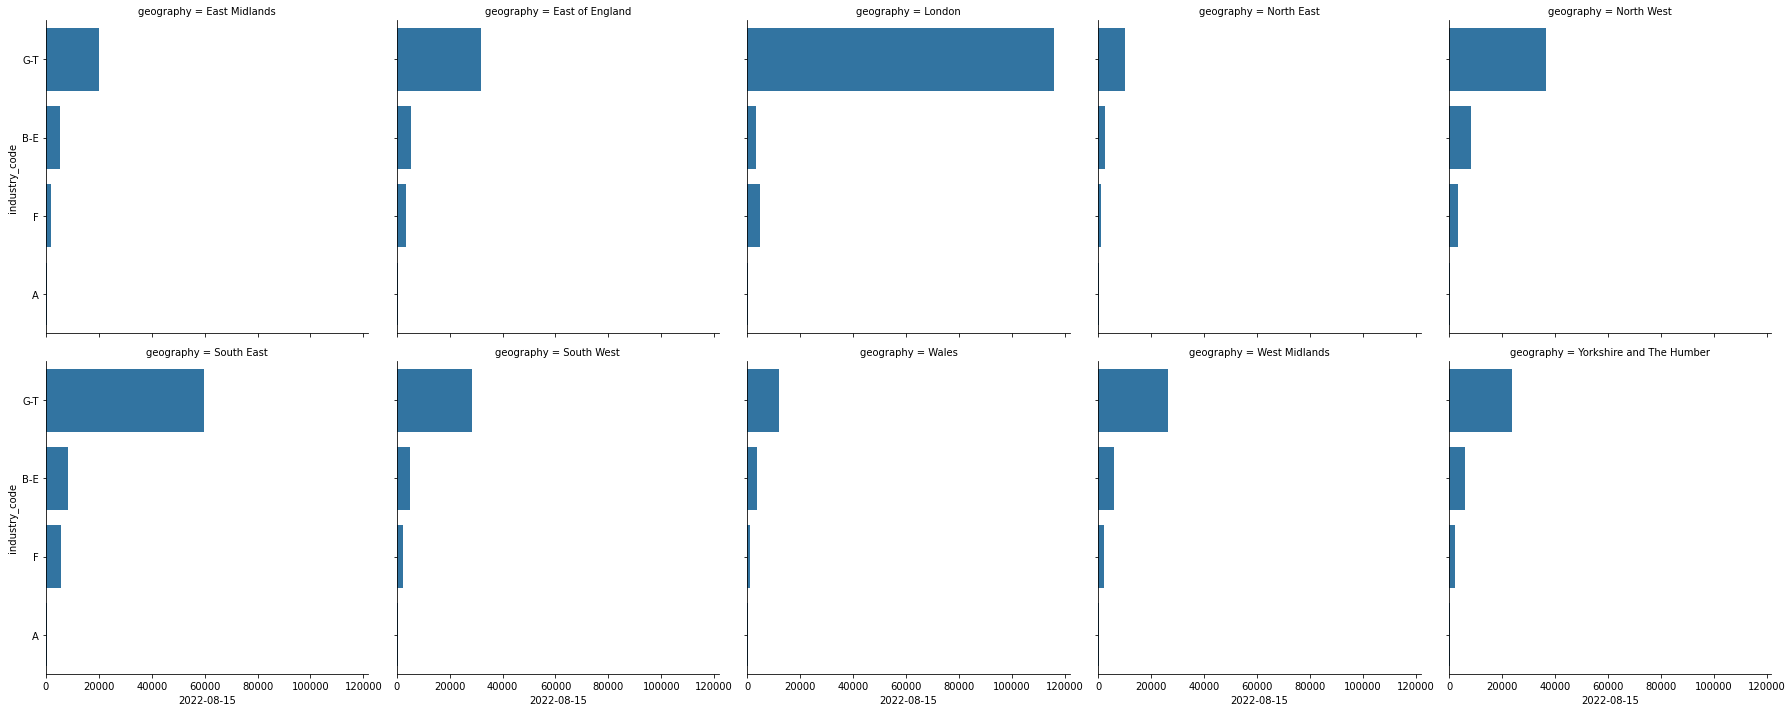

In [23]:
sns.catplot(data= ind_by_region,
            x = "2022-08-15",
            y ="industry_code", order = ['G-T','B-E',"F","A"],
            #log_scale = True,
            col = "geography",
            kind = "bar", 
            col_wrap = 5)

The plot above contains a lot of information. One outlier, as we expect is London compared to the rest of England and Wales. Let's subset the data into two two location aggregates while keeping the industry disaggregate here.

Let's divide only bewtween London and the rest of England and Wales.

In [23]:
# Get the industry aggregate for the rest of england and wales
rest = ind_by_region.query("geography != 'London'").groupby("industry_code")['2022-08-15'].sum()
# order by the value
rest = pd.DataFrame(rest.sort_values())
rest.columns = ["value"]

# apply the same for london
lond = ind_by_region.query("geography == 'London'").groupby("industry_code")['2022-08-15'].sum()
# order by the value
lond = pd.DataFrame(lond.sort_values())
lond.columns = ['value']

# add the location and concatenate
rest['geography'] = ["Rest of England and Wales" for _ in range(len(rest))]
lond['geography'] = ["London" for _ in range(len(lond))]
df_viz = pd.concat([rest,lond]).reset_index()
# convert the unit to 2019 billion pounds
df_viz

,industry_code,value,geography
0,A,2781.78400,Rest of England and Wales
1,F,23638.26900,Rest of England and Wales
2,B-E,50596.02775,Rest of England and Wales
3,G-T,248486.18450,Rest of England and Wales
4,A,14.94400,London
5,B-E,3385.71100,London
6,F,4830.45750,London
7,G-T,115975.30900,London


(0.0, 260910.493725, 3.5, -0.5)

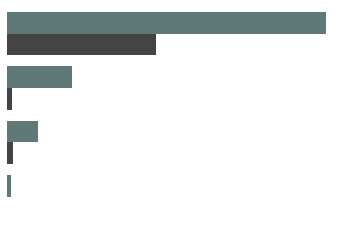

In [24]:
# create a side-by-side bar plot for diagnostic
ax = sns.barplot(data = df_viz,
            x = "value",
            y = 'industry_code',
            hue = "geography",
            hue_order=['Rest of England and Wales',"London"],
            dodge = True,
            order = ["G-T","B-E","F", "A"],
            palette = ["#5A7D7C","#444444"])
ax.get_legend().remove()

plt.axis('off')

The seaborn library generate fairly decent plot. However, if we want more customization, we will have to plot it using the matplotlib library. Let's go back again to see the structure of our dataframe `data_viz`.
Recall that we have also subset the data by geography into the df of `lond` and `rest`.

In [25]:
lond

,value,geography
industry_code,,
A,14.9440,London
B-E,3385.7110,London
F,4830.4575,London
G-T,115975.3090,London


In [26]:
# make sure the order is the same
order = ["A","F","B-E","G-T"]
lond = lond.loc[order,:]
rest = rest.loc[order,:]

# rename the index
df_index = ['Agriculture',"Construction","Production", "Service"]
lond.index = df_index
rest.index = df_index


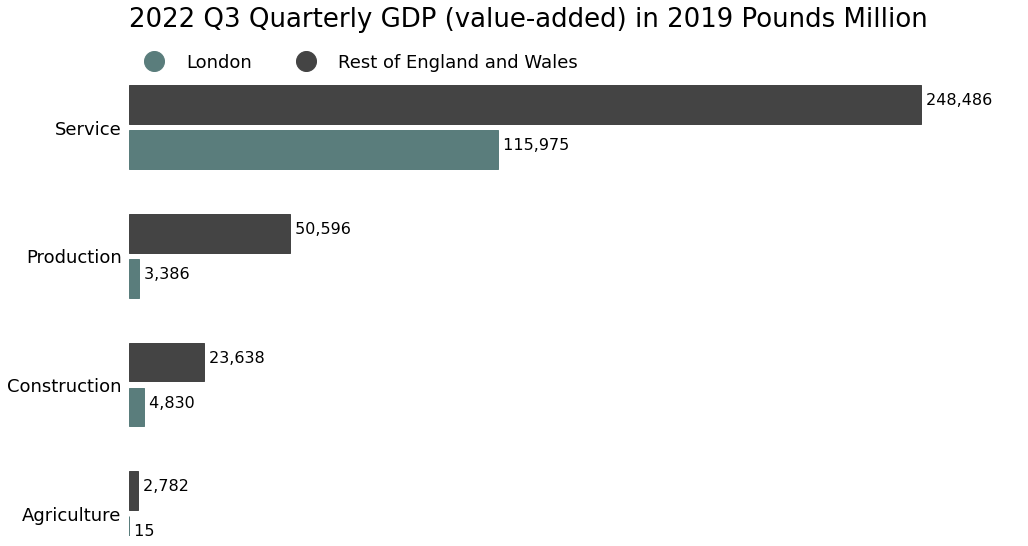

In [27]:
# define locational palette
palette = ["#5A7D7C","#444444"]

# define plot parameters
height = 0.3 # width of bar
y = np.arange(len(lond)) 
gap = 0.05
n = 0
legend_elements = []

# instantiate the plot object
fig, ax  = plt.subplots(figsize = (16,9))

for geog in [lond,rest]:
    # offset ys
    ys = y + height * n + gap * n
    # plot the bars
    rects = ax.barh(width = geog['value'], y = ys, height = height, 
                    color = palette[n], edgecolor = palette[n],
                    )
    # define legend element
    element = Line2D([0],[0], marker = "o", markersize = 20,linewidth = 0,
                     color = palette[n],label = geog.iloc[1,1])
    legend_elements.append(element)
    # add annotation
    for j in range(len(geog)):
        val = geog.iloc[j,0]
        val_str = f"{val: ,.0f}"
        ax.annotate(val_str, xy = (val,ys[j]), fontsize = 16)

    n+=1

# customization
ax.set_title("2022 Q3 Quarterly GDP (value-added) in 2019 Pounds Million", 
             fontsize = 26, loc = "left", pad = 20)
ax.set_yticks(y + (height+gap) /2, df_index, fontsize = 18)
ax.set_xlim(0,280000)
ax.set_ylim(0,3.8)
ax.set_xticks([])
plt.tick_params(axis='both', width = 0)


# add legend
ax.legend(handles = legend_elements,loc = 'upper left',
          ncol = 2, fontsize =  18,
           borderaxespad=0., edgecolor = '#FFFFFF')
ax.dist = 20
fig.savefig("./output_image/gdp_by_region.png", bbox_inches = "tight", 
            dpi = 300,pad_inches = 1)

### Share by Industry

Let's inspect the industry share in London

In [28]:
# subset london data only
london_gdp = real_gdp.query("geography == 'London'")
# subset only the aggregate rows 
london_gdp = london_gdp[london_gdp['industry_code'].isin(["A","B-E","F","G-T", "A-T"])]

# melt the tabble
london_gdp_melt = london_gdp.melt(
            id_vars = 'industry',
            value_vars= timestamp_col,
            value_name= "value",
            var_name="date"
)

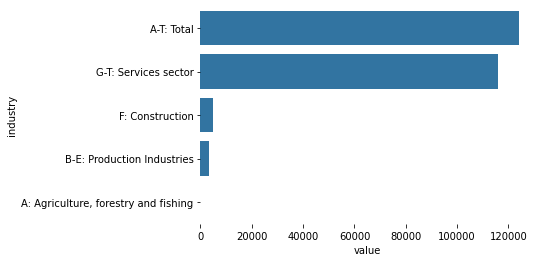

In [29]:
ax = sns.barplot(
    data = london_gdp_melt[london_gdp_melt['date'] == "2022-08-15"].sort_values("value",ascending= False),
    x = "value",
    y = "industry"
)
# ax.legend("off")

## Contribution to Growth Rate by Industry
We look at the annual growth rate to ignore the impact of autocorrelation in the percentage change calculation.

In [30]:
# subset only the relevant dates
london_gdp_2022 = london_gdp[["industry_code","2021-08-15","2022-08-15"]]
# compute the pct change
london_gdp_2022['pct_chg'] = (london_gdp_2022['2022-08-15'] - london_gdp_2022['2021-08-15']) / london_gdp_2022['2021-08-15']
london_gdp_2022['weight'] = london_gdp["2021-08-15"] / london_gdp.query("industry_code == 'A-T'")['2021-08-15'].values
london_gdp_2022['weighted_gr'] = london_gdp_2022['weight'] * london_gdp_2022['pct_chg']
# inspect result
london_gdp_2022


<ipython-input-30-84317948e102>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_gdp_2022['pct_chg'] = (london_gdp_2022['2022-08-15'] - london_gdp_2022['2021-08-15']) / london_gdp_2022['2021-08-15']
<ipython-input-30-84317948e102>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_gdp_2022['weight'] = london_gdp["2021-08-15"] / london_gdp.query("industry_code == 'A-T'")['2021-08-15'].values
<ipython-input-30-84317948e102>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,industry_code,2021-08-15,2022-08-15,pct_chg,weight,weighted_gr
46,A-T,116350.42400,124218.3830,0.067623,1.000000,6.762295e-02
47,A,14.84800,14.9440,0.006466,0.000128,8.250937e-07
48,B-E,3891.04100,3385.7110,-0.129870,0.033442,-4.343173e-03
53,F,5269.08525,4830.4575,-0.083246,0.045286,-3.769885e-03
54,G-T,107172.62900,115975.3090,0.082136,0.921119,7.565662e-02


We will compute the same matrix for the rest of England and Wales

In [31]:
# subset for relevant columns
rest_gdp_2022 = real_gdp[['geography','industry_code','2021-08-15','2022-08-15']]
# subset for industry_aggregate
rest_gdp_2022 = rest_gdp_2022[rest_gdp_2022['industry_code'].isin(["A","B-E","F","G-T", "A-T"])]

# get the region aggregate
rest_gdp_2022 = rest_gdp_2022.groupby("industry_code").sum().select_dtypes("float").reset_index()
# compute pct_change
rest_gdp_2022["pct_chg"] = (rest_gdp_2022["2022-08-15"] - rest_gdp_2022["2021-08-15"]) / rest_gdp_2022["2021-08-15"]
# compute the weight
rest_gdp_2022['weight'] = rest_gdp_2022["2021-08-15"] /  \
        rest_gdp_2022.query("industry_code == 'A-T'")['2021-08-15'].values
# weighted growth 
rest_gdp_2022['weighted_gr'] = rest_gdp_2022['weight'] * rest_gdp_2022['pct_chg']
# inspect result
rest_gdp_2022

,industry_code,2021-08-15,2022-08-15,pct_chg,weight,weighted_gr
0,A,2746.29400,2796.72800,0.018364,0.006251,0.000115
1,A-T,439360.69450,449711.47675,0.023559,1.000000,0.023559
2,B-E,62093.88150,53981.73875,-0.130643,0.141328,-0.018464
3,F,27797.93575,28468.72650,0.024131,0.063269,0.001527
4,G-T,346735.20625,364461.49350,0.051123,0.789181,0.040346


<Axes: >

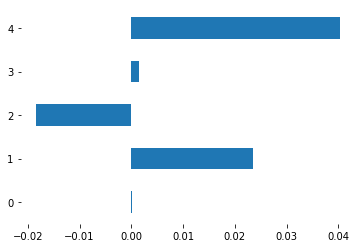

In [32]:
rest_gdp_2022['weighted_gr'].plot.barh()

<Axes: >

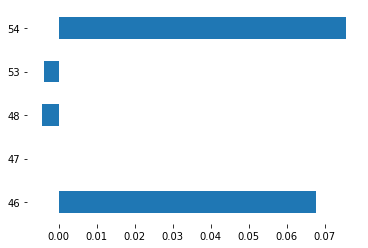

In [33]:
london_gdp_2022['weighted_gr'].plot.barh()

Similar to the aggregate gdp plot, we would combine the two region's plot into one

In [34]:
# set the industry code as index and order by previously defined 
lond = london_gdp_2022.set_index("industry_code").loc[order,:]
rest = rest_gdp_2022.set_index("industry_code").loc[order,:]

# rename the index 
lond.index = df_index
rest.index = df_index

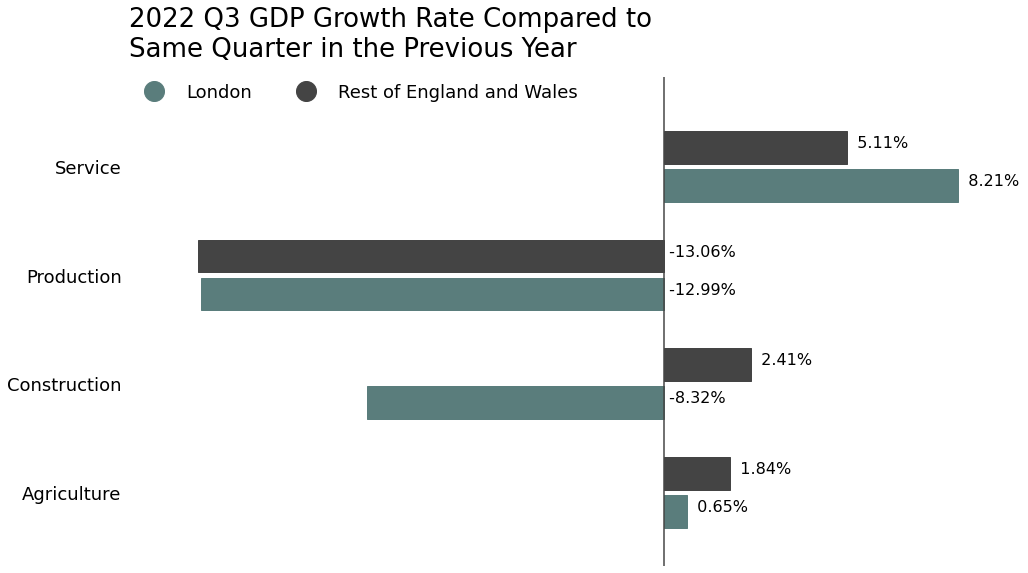

In [42]:
# define locational palette
palette = ["#5A7D7C","#444444"]

# define plot parameters
height = 0.3 # width of bar
y = np.arange(len(lond)) 
gap = 0.05
n = 0
legend_elements = []

# instantiate the plot object
fig, ax  = plt.subplots(figsize = (16,9))

for geog in [lond,rest]:
    # offset ys
    ys = y + height * n + gap * n
    # plot the bars
    rects = ax.barh(width = geog['pct_chg'], y = ys, height = height, 
                    color = palette[n], edgecolor = palette[n],
                    )
    # define legend element
    element = Line2D([0],[0], marker = "o", markersize = 20,linewidth = 0,
                     color = palette[n],label = ["London","Rest of England and Wales"][n] )
    legend_elements.append(element)
    # add annotation
    for j in range(len(geog)):
        val = geog.iloc[j,2]
        val_str = f" {val: ,.2%}"
        ax.annotate(val_str, xy = (max([0,val]),ys[j]), fontsize = 16)

    # iterate next 
    n+=1

# customization
ax.set_title("2022 Q3 GDP Growth Rate Compared to \nSame Quarter in the Previous Year", 
             fontsize = 26, loc = "left", pad = 20)
ax.set_yticks(y + (height+gap) /2, df_index, fontsize = 18)
ax.set_xlim(-0.15,0.1)
ax.set_ylim(-0.5,4)
ax.set_xticks([])
plt.tick_params(axis='both', width = 0)


# add legend
ax.legend(handles = legend_elements,loc = 'upper left',
          ncol = 2, fontsize =  18,
           borderaxespad=0., edgecolor = '#FFFFFF')
ax.dist = 20

# add verticles
ax.axvline(x = 0,color = "#444444")

fig.savefig("./output_image/gdp_gr_by_region.png", bbox_inches = "tight", 
            dpi = 300,pad_inches = 1)

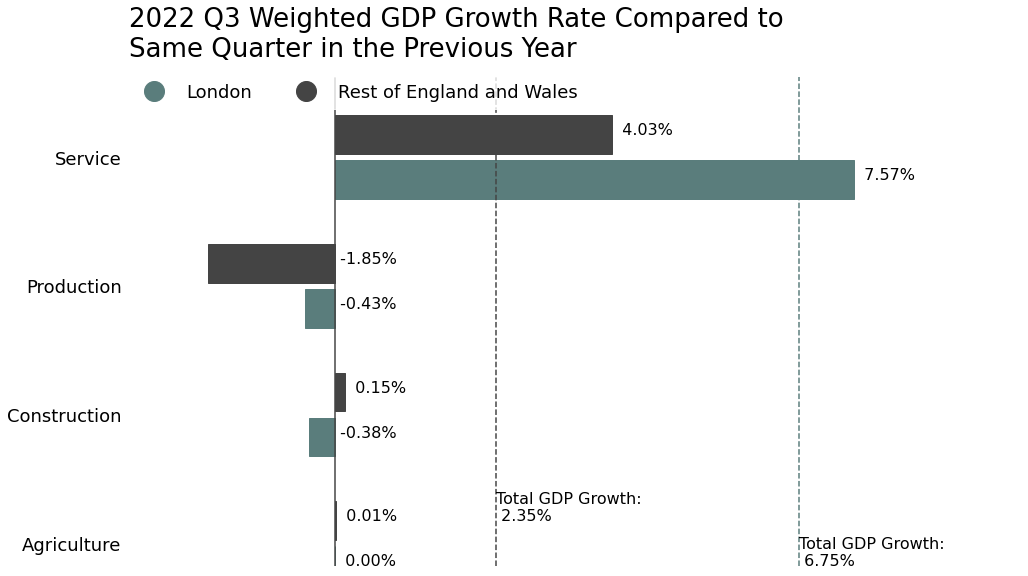

In [36]:
# define locational palette
palette = ["#5A7D7C","#444444"]

# define plot parameters
height = 0.3 # width of bar
y = np.arange(len(lond)) 
gap = 0.05
n = 0
legend_elements = []

# instantiate the plot object
fig, ax  = plt.subplots(figsize = (16,9))

for geog in [lond,rest]:
    # offset ys
    ys = y + height * n + gap * n
    # plot the bars
    rects = ax.barh(width = geog['weighted_gr'], y = ys, height = height, 
                    color = palette[n], edgecolor = palette[n],
                    )
    # define legend element
    element = Line2D([0],[0], marker = "o", markersize = 20,linewidth = 0,
                     color = palette[n],label = ["London","Rest of England and Wales"][n] )
    legend_elements.append(element)
    # add annotation
    for j in range(len(geog)):
        val = geog.iloc[j,4]
        val_str = f" {val: ,.2%}"
        ax.annotate(val_str, xy = (max([0,val]),ys[j]), fontsize = 16)

    # add total 
    gr_tot = geog['weighted_gr'].sum()
    ax.axvline(x = gr_tot,color = palette[n], 
               linestyle = "--",zorder = 3,
               )
    ax.annotate(f"Total GDP Growth:\n{gr_tot: ,.2%}", xy = (gr_tot,ys[0]), fontsize = 16)

    # iterate next 
    n+=1

# customization
ax.set_title("2022 Q3 Weighted GDP Growth Rate Compared to \nSame Quarter in the Previous Year", 
             fontsize = 26, loc = "left", pad = 20)
ax.set_yticks(y + (height+gap) /2, df_index, fontsize = 18)
ax.set_xlim(-0.03,0.1)
ax.set_ylim(0,3.8)
ax.set_xticks([])
plt.tick_params(axis='both', width = 0)


# add legend
ax.legend(handles = legend_elements,loc = 'upper left',
          ncol = 2, fontsize =  18,
           borderaxespad=0., edgecolor = '#FFFFFF')
ax.dist = 20

# add verticles
ax.axvline(x = 0,color = "#444444")

fig.savefig("./output_image/gdp_wgr_by_region.png", bbox_inches = "tight", 
            dpi = 300,pad_inches = 1)

In [119]:
lond['weighted_gr'].sum()

0.06754438857910816

## Testing Site

In [135]:
# subset only the east midlands
e_midlands_gdp = real_gdp.query("geography == 'East Midlands'")
# drop the irrelevant cols and set industry_code as index
e_midlands_gdp = e_midlands_gdp.drop(columns = ['geography','industry'])
e_midlands_gdp = e_midlands_gdp.set_index("industry_code")
# inspect the result
by_sector = e_midlands_gdp.transpose().pct_change()


In [138]:
# drop the aggregate columns
by_sector = by_sector.drop(columns = ["B-E","G-T","A-T"])
by_sector.head()

In [142]:
e_midlands_gdp.transpose().head()

industry_code,A-T,A,B-E,B,C,D,E,F,G-T,G,...,K,L,M,N,O,P,Q,R,S,T
2012-02-14,2485856.5,33664.275,475773.15,8851.45,406767.5,33215.875,40236.000,166455.0,1810627.075,334509.475,...,102536.5,284930.8,137583.2,102745.625,120484.925,179066.825,232753.8,34402.125,42571.700,2672.25
2012-05-15,2502863.5,34737.525,493372.65,9917.00,413467.2,43199.125,36320.175,172327.5,1802588.775,333471.700,...,103079.5,292384.4,114752.8,109506.950,118901.200,182692.475,238999.0,33122.850,42733.775,2724.75
2012-08-15,2534043.0,35453.025,499825.80,8165.70,420166.9,45109.500,35853.150,172125.0,1828713.250,343503.525,...,101903.0,297466.4,118207.4,112821.325,120119.450,181483.925,239719.6,38239.950,44084.400,3160.50
2012-11-15,2548215.5,33843.150,504519.00,8608.80,424952.4,44863.000,35781.300,178200.0,1832732.400,344541.300,...,98192.5,296450.0,124966.4,124620.500,115611.925,179268.250,234915.6,33641.475,43382.075,3333.75
2013-02-14,2545381.0,31625.100,505105.65,8904.20,418252.7,49423.250,35565.750,171315.0,1838761.125,341427.975,...,95477.5,298482.8,124065.2,121040.975,115246.450,180678.225,236597.0,34471.275,45543.075,3417.75


In [151]:
e_midlands_gdp.head()

,2012-02-14,2012-05-15,2012-08-15,2012-11-15,2013-02-14,2013-05-15,2013-08-15,2013-11-15,2014-02-14,2014-05-15,...,2020-05-15,2020-08-15,2020-11-15,2021-02-14,2021-05-15,2021-08-15,2021-11-15,2022-02-14,2022-05-15,2022-08-15
industry_code,,,,,,,,,,,,,,,,,,,,,
A-T,2485856.500,2502863.500,2534043.000,2548215.50,2545381.00,2585064.00,2596402.000,2602071.00,2627581.50,2624747.000,...,2162723.500,2638919.50,2678602.500,2681437.00,2803320.500,2843003.500,2851507.00,2843003.5,2820327.500,2777810.000
A,33664.275,34737.525,35453.025,33843.15,31625.10,31052.70,32304.825,34129.35,44504.10,44110.575,...,30301.425,32340.60,32877.225,34701.75,37456.425,40676.175,39710.25,39781.8,40246.875,40890.825
B-E,475773.150,493372.650,499825.800,504519.00,505105.65,536198.10,545584.500,549104.40,533264.85,529744.950,...,494545.950,639448.50,650008.200,654114.75,650008.200,663501.150,633582.00,610116.0,583130.100,553210.950
B,8851.450,9917.000,8165.700,8608.80,8904.20,9632.15,10180.750,11605.00,9832.60,9684.900,...,7923.050,10307.35,10528.900,11351.80,11573.350,11794.900,12143.05,12849.9,11583.900,11868.750
C,406767.500,413467.200,420166.900,424952.40,418252.70,446008.60,456058.150,461800.75,456058.15,447922.800,...,391453.900,519226.75,532626.150,526883.55,521140.950,538847.300,517791.10,500563.3,471371.750,441701.650


In [139]:
by_sector.head()

industry_code,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
2012-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-15,0.031881,0.120381,0.016471,0.300557,-0.097321,0.035280,-0.003102,-0.025880,0.006188,-0.053354,0.005296,0.026159,-0.165939,0.065806,-0.013145,0.020247,0.026832,-0.037186,0.003807,0.019646
2012-08-15,0.020597,-0.176596,0.016204,0.044223,-0.012859,-0.001175,0.030083,-0.002125,0.033210,-0.027375,-0.011414,0.017381,0.030105,0.030266,0.010246,-0.006615,0.003015,0.154489,0.031606,0.159923
2012-11-15,-0.045409,0.054264,0.011390,-0.005464,-0.002004,0.035294,0.003021,0.009585,0.061905,0.006623,-0.036412,-0.003417,0.057179,0.104583,-0.037525,-0.012209,-0.020040,-0.120253,-0.015931,0.054817
2013-02-14,-0.065539,0.034314,-0.015766,0.101648,-0.006024,-0.038636,-0.009036,0.025316,0.043722,0.026316,-0.027650,0.006857,-0.007212,-0.028723,-0.003161,0.007865,0.007157,0.024666,0.049813,0.025197


In [134]:
# gr = df.query("index == 'Quarterly index'")
e_midlands_gr = df[(df['index'] == "Quarterly growth rate on previous quarter") &
                   (df['geography'] == "East Midlands")]
# pivot to get the growth rate by industry 
e_midlands_gr = e_midlands_gr.pivot(index = ['geography','industry_code'],
                    values = 'value',
                    columns= 'timestamp')\
                    .reset_index()
# drop the irrelevant columns 
e_midlands_gr = e_midlands_gr.drop(columns = ['geography'])
e_midlands_gr = e_midlands_gr.set_index("industry_code", drop = True)
e_midlands_gr.transpose().head()

industry_code,A,A--T,B,B--E,C,D,E,F,G,G--T,...,K,L,M,N,O,P,Q,R,S,T
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-02-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-15 00:00:00,3.2,0.7,12.0,3.7,1.7,30.2,-9.7,3.5,-0.3,-0.5,...,0.5,2.7,-16.6,6.5,-1.3,2.0,2.7,-3.7,0.4,2.1
2012-08-15 00:00:00,2.0,1.3,-17.7,1.3,1.5,4.4,-1.3,0.0,3.0,1.5,...,-1.1,1.7,3.0,3.0,1.0,-0.7,0.3,15.4,3.1,15.9
2012-11-15 00:00:00,-4.5,0.5,5.5,0.9,1.1,-0.5,-0.2,3.5,0.3,0.2,...,-3.6,-0.3,5.8,10.5,-3.7,-1.3,-2.0,-12.1,-1.5,5.5
2013-02-14 00:00:00,-6.7,-0.1,3.5,0.0,-1.6,10.1,-0.6,-3.9,-0.9,0.3,...,-2.8,0.7,-0.8,-2.8,-0.3,0.9,0.7,2.5,4.9,2.6


In [131]:
e_midlands_gr.columns

Index([        'geography',     'industry_code', 2012-02-14 00:00:00,
       2012-05-15 00:00:00, 2012-08-15 00:00:00, 2012-11-15 00:00:00,
       2013-02-14 00:00:00, 2013-05-15 00:00:00, 2013-08-15 00:00:00,
       2013-11-15 00:00:00, 2014-02-14 00:00:00, 2014-05-15 00:00:00,
       2014-08-15 00:00:00, 2014-11-15 00:00:00, 2015-02-14 00:00:00,
       2015-05-15 00:00:00, 2015-08-15 00:00:00, 2015-11-15 00:00:00,
       2016-02-14 00:00:00, 2016-05-15 00:00:00, 2016-08-15 00:00:00,
       2016-11-15 00:00:00, 2017-02-14 00:00:00, 2017-05-15 00:00:00,
       2017-08-15 00:00:00, 2017-11-15 00:00:00, 2018-02-14 00:00:00,
       2018-05-15 00:00:00, 2018-08-15 00:00:00, 2018-11-15 00:00:00,
       2019-02-14 00:00:00, 2019-05-15 00:00:00, 2019-08-15 00:00:00,
       2019-11-15 00:00:00, 2020-02-14 00:00:00, 2020-05-15 00:00:00,
       2020-08-15 00:00:00, 2020-11-15 00:00:00, 2021-02-14 00:00:00,
       2021-05-15 00:00:00, 2021-08-15 00:00:00, 2021-11-15 00:00:00,
       2022-02-14 00

In [146]:
be_gdp_sum = e_midlands_gdp.iloc[3:7,0].sum()

In [154]:
aggregate = 0
for i in range(3,7): 
    rate = by_sector.iloc[1,i-2]
    gdp = e_midlands_gdp.iloc[i,2]
    aggregate += rate * gdp / be_gdp_sum


In [168]:
gva['geography'].unique()

array(['United Kingdom', 'England', 'North East', 'North West',
       'Yorkshire and The Humber', 'East Midlands', 'West Midlands',
       'East of England', 'London', 'South East', 'South West', 'Wales',
       'Scotland', 'Northern Ireland', 'Extra-Regio',
       'United Kingdom less Extra-Regio'], dtype=object)

In [31]:
inspect = gva[["geography","industry_code",'val_2019']]
inspect = inspect.query("industry_code == 'A-T'")
inspect['val_2019'] = inspect['val_2019'] / 1000000

In [32]:
inspect

,geography,industry_code,val_2019
0,United Kingdom,A-T,2.000157
107,England,A-T,1.720794
214,North East,A-T,0.056008
321,North West,A-T,0.190312
428,Yorkshire and The Humber,A-T,0.128608
535,East Midlands,A-T,0.113380
642,West Midlands,A-T,0.143658
749,East of England,A-T,0.169013
856,London,A-T,0.476846
963,South East,A-T,0.296182


In [39]:
real_gdp.query("industry_code == 'A-T'")

,geography,industry,industry_code,2012-02-14,2012-05-15,2012-08-15,2012-11-15,2013-02-14,2013-05-15,2013-08-15,...,2020-05-15,2020-08-15,2020-11-15,2021-02-14,2021-05-15,2021-08-15,2021-11-15,2022-02-14,2022-05-15,2022-08-15
0,East Midlands,A-T: Total,A-T,2485856.500,2502863.500,2.534043e+06,2548215.500,2.545381e+06,2.585064e+06,2.596402e+06,...,2162723.500,2.638920e+06,2.678602e+06,2.681437e+06,2.803320e+06,2.843004e+06,2.851507e+06,2.843004e+06,2820327.50,2.777810e+06
23,East of England,A-T: Total,A-T,3490118.450,3502794.425,3.570400e+06,3587300.925,3.587301e+06,3.587301e+06,3.638005e+06,...,3211247.000,3.768990e+06,3.840820e+06,3.870398e+06,4.056312e+06,4.123917e+06,4.204198e+06,4.187297e+06,4183071.75,4.149269e+06
46,London,A-T: Total,A-T,9668052.650,9811106.450,1.002569e+07,9989923.700,1.014490e+07,1.006145e+07,1.020450e+07,...,9608446.900,1.059790e+07,1.081248e+07,1.084825e+07,1.136086e+07,1.163504e+07,1.209997e+07,1.214765e+07,12314547.95,1.242184e+07
69,North East,A-T: Total,A-T,1274182.000,1269981.400,1.279783e+06,1271381.600,1.251779e+06,1.271382e+06,1.254579e+06,...,1057151.000,1.232176e+06,1.264381e+06,1.271382e+06,1.334391e+06,1.358194e+06,1.370796e+06,1.377797e+06,1366595.20,1.376397e+06
92,North West,A-T: Total,A-T,4010825.400,4029856.600,4.072677e+06,4086950.200,4.077435e+06,4.134528e+06,4.134528e+06,...,3663506.000,4.305809e+06,4.339114e+06,4.348629e+06,4.600793e+06,4.719738e+06,4.805378e+06,4.829167e+06,4848198.20,4.848198e+06
115,South East,A-T: Total,A-T,6330890.250,6397531.200,6.449363e+06,6434553.950,6.434554e+06,6.493790e+06,6.538218e+06,...,5827380.850,6.723331e+06,6.901041e+06,6.782568e+06,7.189818e+06,7.249054e+06,7.389741e+06,7.441573e+06,7411954.55,7.404550e+06
138,South West,A-T: Total,A-T,3218261.125,3221930.750,3.262297e+06,3273305.500,3.229270e+06,3.243948e+06,3.269636e+06,...,2854968.250,3.328350e+06,3.343028e+06,3.332020e+06,3.548527e+06,3.607241e+06,3.632929e+06,3.636598e+06,3610911.00,3.629259e+06
161,Wales,A-T: Total,A-T,1454237.000,1461032.500,1.479720e+06,1478021.250,1.478021e+06,1.483118e+06,1.495010e+06,...,1323423.625,1.549374e+06,1.569760e+06,1.551073e+06,1.658102e+06,1.686983e+06,1.693778e+06,1.680187e+06,1685284.00,1.651306e+06
184,West Midlands,A-T: Total,A-T,2984494.950,3041958.150,3.092238e+06,3103012.800,3.095830e+06,3.138927e+06,3.120970e+06,...,2743867.800,3.261037e+06,3.343640e+06,3.318500e+06,3.476524e+06,3.494481e+06,3.516030e+06,3.498072e+06,3516029.55,3.490889e+06
207,Yorkshire and The Humber,A-T: Total,A-T,2774717.600,2816515.200,2.845452e+06,2848667.200,2.848667e+06,2.851882e+06,2.839022e+06,...,2469273.600,2.941908e+06,2.980490e+06,2.961199e+06,3.141250e+06,3.218415e+06,3.202339e+06,3.218415e+06,3231276.00,3.221630e+06
